In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os

In [3]:
from matplotlib.dates import DateFormatter

In [4]:
# Update rcParams to set the default font to Times New Roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'

# Memilio

In [6]:
experiment_series = "MEmilio Output - 03 April 2024"
memilio_output_path = os.path.join("memilio_output", experiment_series)

In [7]:
df = pd.read_csv(os.path.join(memilio_output_path, f"{2}_console_output.csv"), sep=",", index_col=False)

In [8]:
"""
Based on the console output of the MEmilio simulation, we can get the prevalence of the disease over time.
The prevalence is the sum of the number of exposed, carriers, symptomatic, severe, and critical cases.
Note that in the newest version of MEmilio, the console output is not automatically stored anymore,
hence, the console output was created manually based on the infection paths. 
"""
def tidy_console_output(memilio_output_path, memilio_id):
    df = pd.read_csv(os.path.join(memilio_output_path, f"{memilio_id}_console_output.csv"), sep=",", index_col=False)
    df["time"] = pd.to_datetime(df["ts"], unit="d", origin=pd.Timestamp('2024-01-01'))
    df["memilio_id"] = memilio_id
    df = df[["time", "memilio_id", "numS","numE","numI_ns","numI_sy","numI_sev","numI_cri","numR","numD"]]
    df.columns = [ "time", "memilio_id", "S", "E", "C", "I", "I_s", "I_c", "R", "D"]
    df["I_total"] = df["E"] +  df["C"] + df["I_s"] + df["I_c"] + df["I"] # total cases (i.e. prevalence) are asymptomatic + severe + critical + mild with symptoms (C is carrier)
    return df


In [9]:
df_res = [tidy_console_output(memilio_output_path, memilio_id) for memilio_id in range(1, 251)]
df_res = pd.concat(df_res)
df_res.to_csv(os.path.join(memilio_output_path, "console_output_summarized.csv"), index=False)

In [10]:
df = pd.read_csv(os.path.join(memilio_output_path, f"console_output_summarized.csv"))
df["time"] = pd.to_datetime(df["time"])

/tmp/ipykernel_79589/1369285427.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


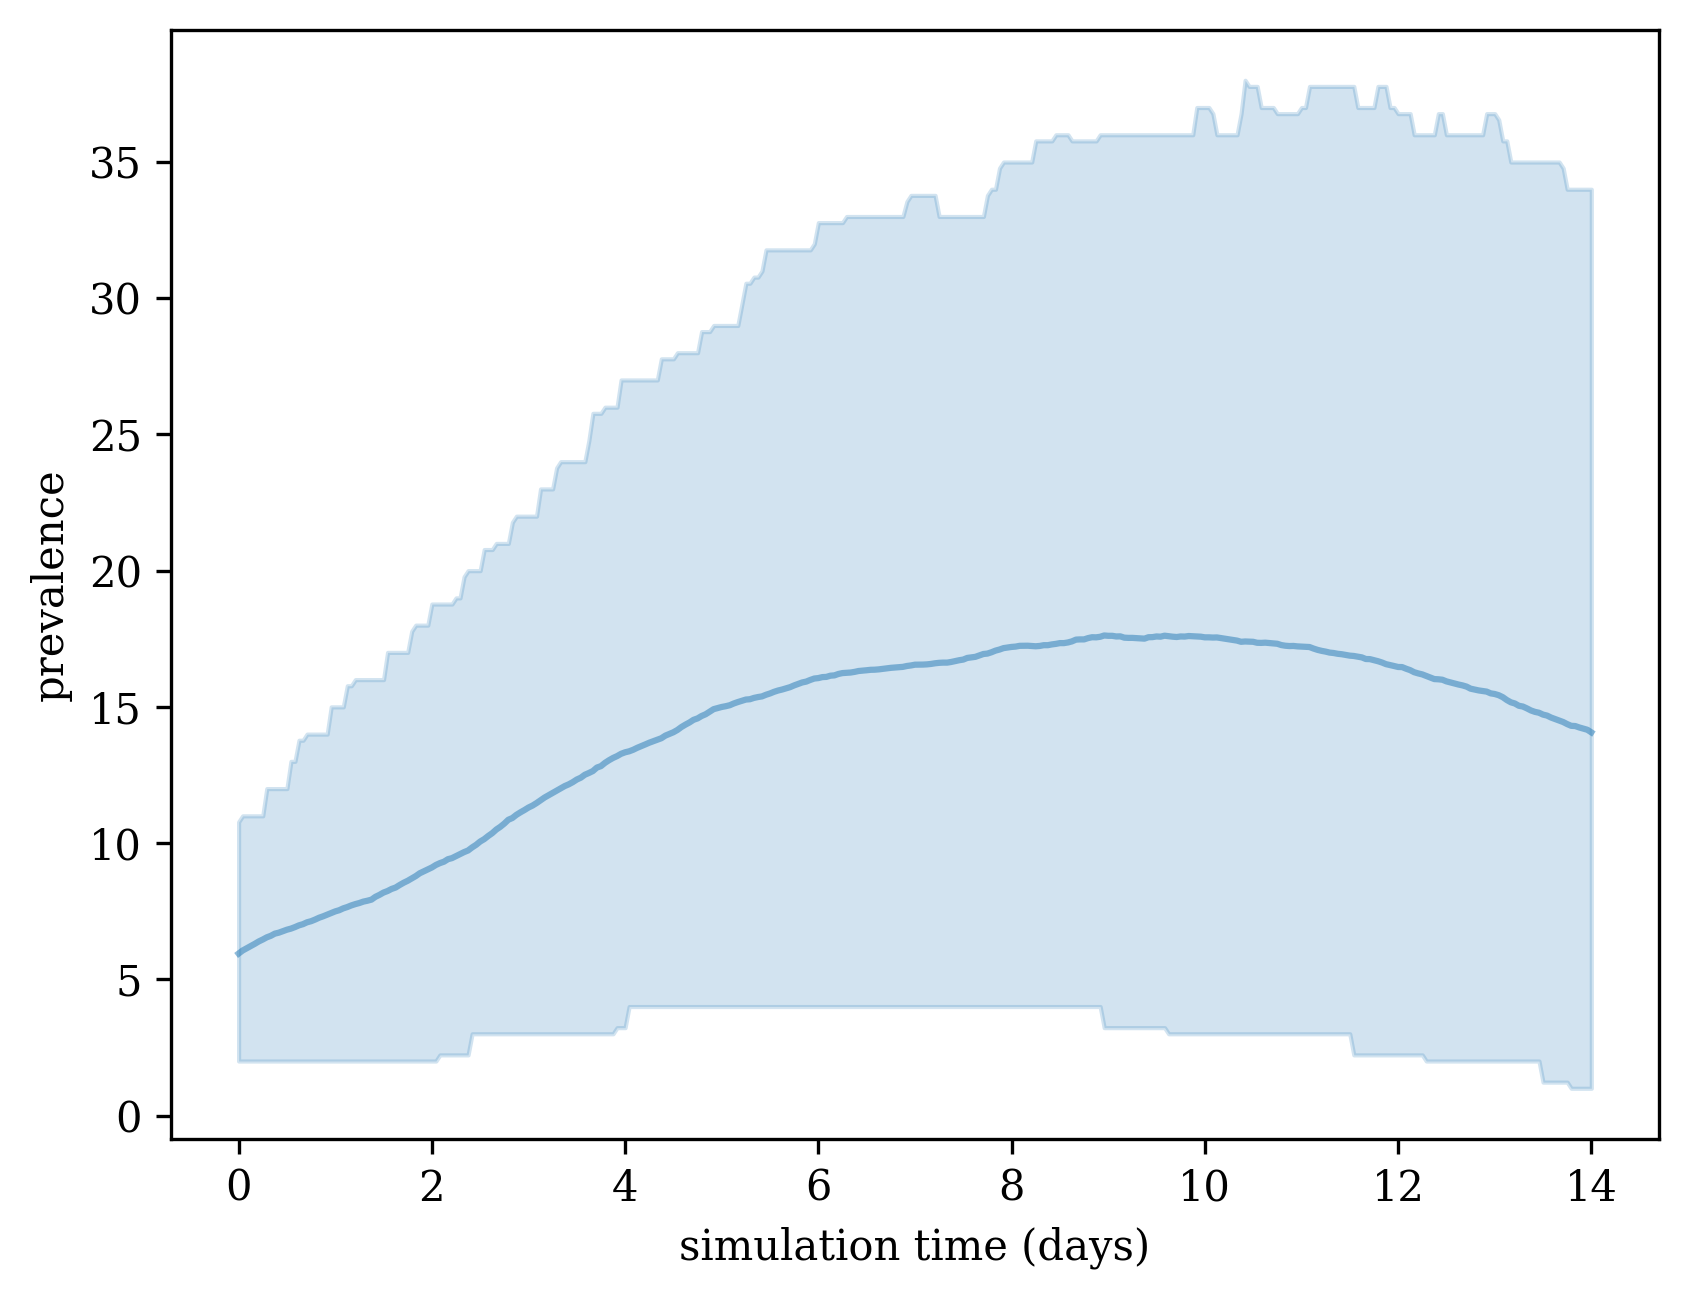

In [11]:
fig, ax = plt.subplots(dpi=300)    
sns.lineplot(data=df, x="time", y="I_total", alpha=0.5, errorbar="pi")
# plt.title('Prevalence - 95% prediction interval of simulation')
plt.xlabel('simulation time (days)')
plt.ylabel('prevalence')
date_form = DateFormatter("%d")
ax.xaxis.set_major_formatter(date_form)
ax.set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
plt.savefig(os.path.join("memilio_output", "prevalence.png"))

# ++Systems

In [5]:
experiment_series = "reaktionstests" # base or reaktionstests
degradation_setting = "no_degradation" 
rain_scenario = "Nieselregen"

subexperiment = degradation_setting #rain_scenario

In [6]:
if experiment_series == "PMMoV":
    systems_output_path = os.path.join("systems_output", experiment_series, f"PMMoV_{degradation_setting}_{rain_scenario}")
else:
    systems_output_path = os.path.join("systems_output", experiment_series, f"{degradation_setting}_{rain_scenario}")# , "Euler")

In [7]:
systems_output_path

'systems_output/reaktionstests/no_degradation_Nieselregen'

In [8]:
"""
For a specific systems simulation scenario, get an overview over: 
    - measurment points, 
    - memilio ids (i.e. iterations)
    - concentration files (for further preprocessing of the output of the simulations)
"""
def get_overview_of_systems_output(systems_output_path):
    flow_rate_files = [el for el in os.listdir(systems_output_path) if ("flow_rate" in el)]
    concentration_files = [el for el in os.listdir(systems_output_path) if ("INSIDe_substances_results" in el) and not ("Sampling" in el)]
    measurement_points = np.unique([el.split(".")[0] for el in [el.split("_")[-1] for el in concentration_files]])
    memilio_ids = np.unique([int(el.split("results_")[1].split("_")[0]) for el in concentration_files])

    # measurement points
    # assert len(np.unique([el.split("pipe_")[1].split("_")[0] for el in flow_rate_files])) == 90 # does this hold for all experiments?
    # memilio_ids
    assert set(np.unique([int(el.split("results_")[1].split("_")[0]) for el in flow_rate_files])) == set(memilio_ids)

    flow_rate_files = [el for el in flow_rate_files if el.split("pipe_")[1].split("_")[0] in measurement_points]
    flow_rate_measurement_points = np.unique([el.split("pipe_")[1].split("_")[0] for el in flow_rate_files if el.split("pipe_")[1].split("_")[0] in measurement_points])
    assert len(flow_rate_measurement_points) == 15
    
    return flow_rate_files, concentration_files, measurement_points, memilio_ids

flow_rate_files, concentration_files, measurement_points, memilio_ids = get_overview_of_systems_output(systems_output_path)

print(f"Measurement Points: {measurement_points} \n")
print(f"Memilio Iterations: {memilio_ids}")
print(f"N Iterations: {len(memilio_ids)}") # this should be 250

# check for consistency of the results
assert len([el for el in measurement_points if "MW" in el]) == 11
assert len([el for el in measurement_points if "RW" in el]) == 7
assert len(memilio_ids) == 250

Measurement Points: ['MW017' 'MW022' 'MW023' 'MW043' 'MW046' 'MW048' 'MW052' 'MW054' 'MW059'
 'MW061' 'MW064' 'RW126' 'RW141' 'RW143' 'RW155' 'RW156' 'RW157' 'RW211'] 

Memilio Iterations: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200

In [9]:
# file_name = flow_rate_files[0]

"""
For a specific systems simulation scenario, get the results of the INSIDe flow simulations in a tidy data format
"""
def tidy_INSIDe_flow_results(systems_output_path, file_name):
    print(file_name)
    df = pd.read_csv(os.path.join(systems_output_path, file_name), sep="\t", decimal=".")
    df.rename(columns={"t [min] ": "minutes", " flow rate [l/s]":"l/s"}, inplace=True)
    assert np.array_equal(df.minutes, df.minutes.astype(int)) # check whether minutes are all integer
    df["minutes"] = df["minutes"].astype(int)
    df["sampling_point"] = file_name.split("pipe_")[-1].split("_")[0]
    df["memilio_id"] = int(file_name.split("results_")[1].split("_")[0])
    df["time"] = pd.to_datetime(df["minutes"], unit="m", origin=pd.Timestamp('2024-01-01'))
    return df


In [10]:
# tidy the results of the INSIDe substances simulations for all concentration files
df_flow = [tidy_INSIDe_flow_results(systems_output_path, file_name) for file_name in flow_rate_files]# if "38" not in file_name]
df_flow = pd.concat(df_flow)

INSIDe_hydraulic_results_188_output_pipe_MW052_flow_rate.txt
INSIDe_hydraulic_results_3_output_pipe_MW046_flow_rate.txt
INSIDe_hydraulic_results_114_output_pipe_MW046_flow_rate.txt
INSIDe_hydraulic_results_236_output_pipe_RW141_flow_rate.txt
INSIDe_hydraulic_results_49_output_pipe_MW022_flow_rate.txt
INSIDe_hydraulic_results_247_output_pipe_MW043_flow_rate.txt
INSIDe_hydraulic_results_203_output_pipe_MW059_flow_rate.txt
INSIDe_hydraulic_results_125_output_pipe_RW143_flow_rate.txt
INSIDe_hydraulic_results_203_output_pipe_RW141_flow_rate.txt
INSIDe_hydraulic_results_180_output_pipe_MW054_flow_rate.txt
INSIDe_hydraulic_results_51_output_pipe_MW048_flow_rate.txt
INSIDe_hydraulic_results_184_output_pipe_RW141_flow_rate.txt
INSIDe_hydraulic_results_193_output_pipe_MW023_flow_rate.txt
INSIDe_hydraulic_results_217_output_pipe_MW059_flow_rate.txt
INSIDe_hydraulic_results_20_output_pipe_RW156_flow_rate.txt
INSIDe_hydraulic_results_155_output_pipe_MW043_flow_rate.txt
INSIDe_hydraulic_results_139_

In [11]:
if experiment_series == "PMMoV":
    df_flow.to_csv(os.path.join("systems_output", "preprocessed", "PMMoV", f"flow_rates_{degradation_setting}_{rain_scenario}.csv"), index=False)
else:
    df_flow.to_csv(os.path.join("systems_output", "preprocessed", f"flow_rates_{degradation_setting}_{rain_scenario}.csv"), index=False)

In [12]:
# file_name = concentration_files[0]

"""
For a specific systems simulation scenario, get the results of the INSIDe substances simulations in a tidy data format
"""
def tidy_INSIDe_substances_results(systems_output_path, file_name):
    print(file_name)
    df = pd.read_csv(os.path.join(systems_output_path, file_name), sep="\t", decimal=",")
    df.rename(columns={"time[min]": "minutes", "COV19(COV19) concentration [copies/l]":"copies/l"}, inplace=True)
    df_2_index = df.loc[df.minutes=="time[min]", :].index
    df_1 = df.iloc[:df_2_index[0],:].copy()
    df_2 = df.iloc[df_2_index[0]+1:,:].copy()
    df_2.rename(columns={"copies/l": "temperature"}, inplace=True)
    df = df_1.merge(df_2, on="minutes", how="outer")
    df["sampling_point"] = file_name.split("_")[-1].split(".")[0]
    df["memilio_id"] = int(file_name.split("results_")[1].split("_")[0])
    df["minutes"] = df["minutes"].astype(int)
    df["copies/l"] = df["copies/l"].astype(float)
    df["temperature"] = df["temperature"].astype(float)
    df["time"] = pd.to_datetime(df["minutes"], unit="m", origin=pd.Timestamp('2024-01-01'))
    return df

In [13]:
# tidy the results of the INSIDe substances simulations for all concentration files
df_res = [tidy_INSIDe_substances_results(systems_output_path, file_name) for file_name in concentration_files]# if "38" not in file_name]
df_res = pd.concat(df_res)

INSIDe_substances_results_112_output_manhole_RW141.txt
INSIDe_substances_results_30_output_manhole_RW126.txt
INSIDe_substances_results_38_output_manhole_RW126.txt
INSIDe_substances_results_186_output_manhole_RW143.txt
INSIDe_substances_results_163_output_manhole_RW155.txt
INSIDe_substances_results_131_output_manhole_RW143.txt
INSIDe_substances_results_165_output_manhole_RW126.txt
INSIDe_substances_results_5_output_manhole_RW141.txt
INSIDe_substances_results_111_output_manhole_MW064.txt
INSIDe_substances_results_135_output_manhole_MW064.txt
INSIDe_substances_results_78_output_manhole_MW017.txt
INSIDe_substances_results_198_output_manhole_MW061.txt
INSIDe_substances_results_185_output_manhole_MW054.txt
INSIDe_substances_results_130_output_manhole_MW022.txt
INSIDe_substances_results_203_output_manhole_RW126.txt
INSIDe_substances_results_103_output_manhole_RW126.txt
INSIDe_substances_results_27_output_manhole_RW141.txt
INSIDe_substances_results_141_output_manhole_RW141.txt
INSIDe_substance

In [14]:
if experiment_series == "PMMoV":
    df_res.to_csv(os.path.join("systems_output", "preprocessed", "PMMoV", f"{degradation_setting}_{rain_scenario}.csv"), index=False)
else:
    df_res.to_csv(os.path.join("systems_output", "preprocessed", f"{degradation_setting}_{rain_scenario}.csv"), index=False)

## Basic Visualization of Trajectory

In [15]:
#degradation_setting = "linear_decay2"
#rain_scenario = "KeinRegen"

In [9]:
def load_systems_data(degradation_setting, rain_scenario, file_type="concentrations"):
    if file_type=="concentrations":
        df_res = pd.read_csv(os.path.join("systems_output", "preprocessed", f"{degradation_setting}_{rain_scenario}.csv"))
    elif file_type=="flow_rates":
        df_res = pd.read_csv(os.path.join("systems_output", "preprocessed", f"flow_rates_{degradation_setting}_{rain_scenario}.csv"))
    else:
        assert False, f"file_type {file_type} not supported"

    df_res.time = pd.to_datetime(df_res.time)

    # drop MW064, RW156 (invalid calculations of ++systems)
    df_res = df_res.loc[~df_res.sampling_point.isin(["MW064", "RW156"]), :]
    # rename sampling locations according to naming in the paper
    df_res.sampling_point = df_res.sampling_point.map({"MW022": "1", "MW023": "2", "MW017": "3", "MW043": "4", "MW048": "5", 
                        "RW157": "6", "MW046": "7", "MW061": "8", "RW143": "9", "RW141": "10",
                        "RW155": "11", "MW059": "12", "RW211": "13", "MW054": "14",
                        "RW126": "15", "MW052": "16"})
    return df_res

In [16]:
df_res = load_systems_data(degradation_setting, rain_scenario, file_type="concentrations")

In [25]:
def plot_station_trajectory(df_res, station, save_fig=False):
    fig, ax = plt.subplots(figsize = (12,6))    
    sns.lineplot(data=df_res.loc[df_res.sampling_point==station,:], x="time", y="copies/l")
    plt.title(f"{station}")
    plt.xlabel('time (days)')
    plt.ylabel('concentration (copies/l)')
    date_form = DateFormatter("%d")
    ax.xaxis.set_major_formatter(date_form)
    if save_fig:
        plt.savefig(os.path.join("systems_output", "plots", "station_concentration", "individual_plots", f"{degradation_setting}_{rain_scenario}_{station}.png"))
        plt.close(fig)
    else:
        plt.close(fig)
        return fig

/tmp/ipykernel_36161/1654310351.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
/tmp/ipykernel_36161/1654310351.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
/tmp/ipykernel_36161/1654310351.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[i].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


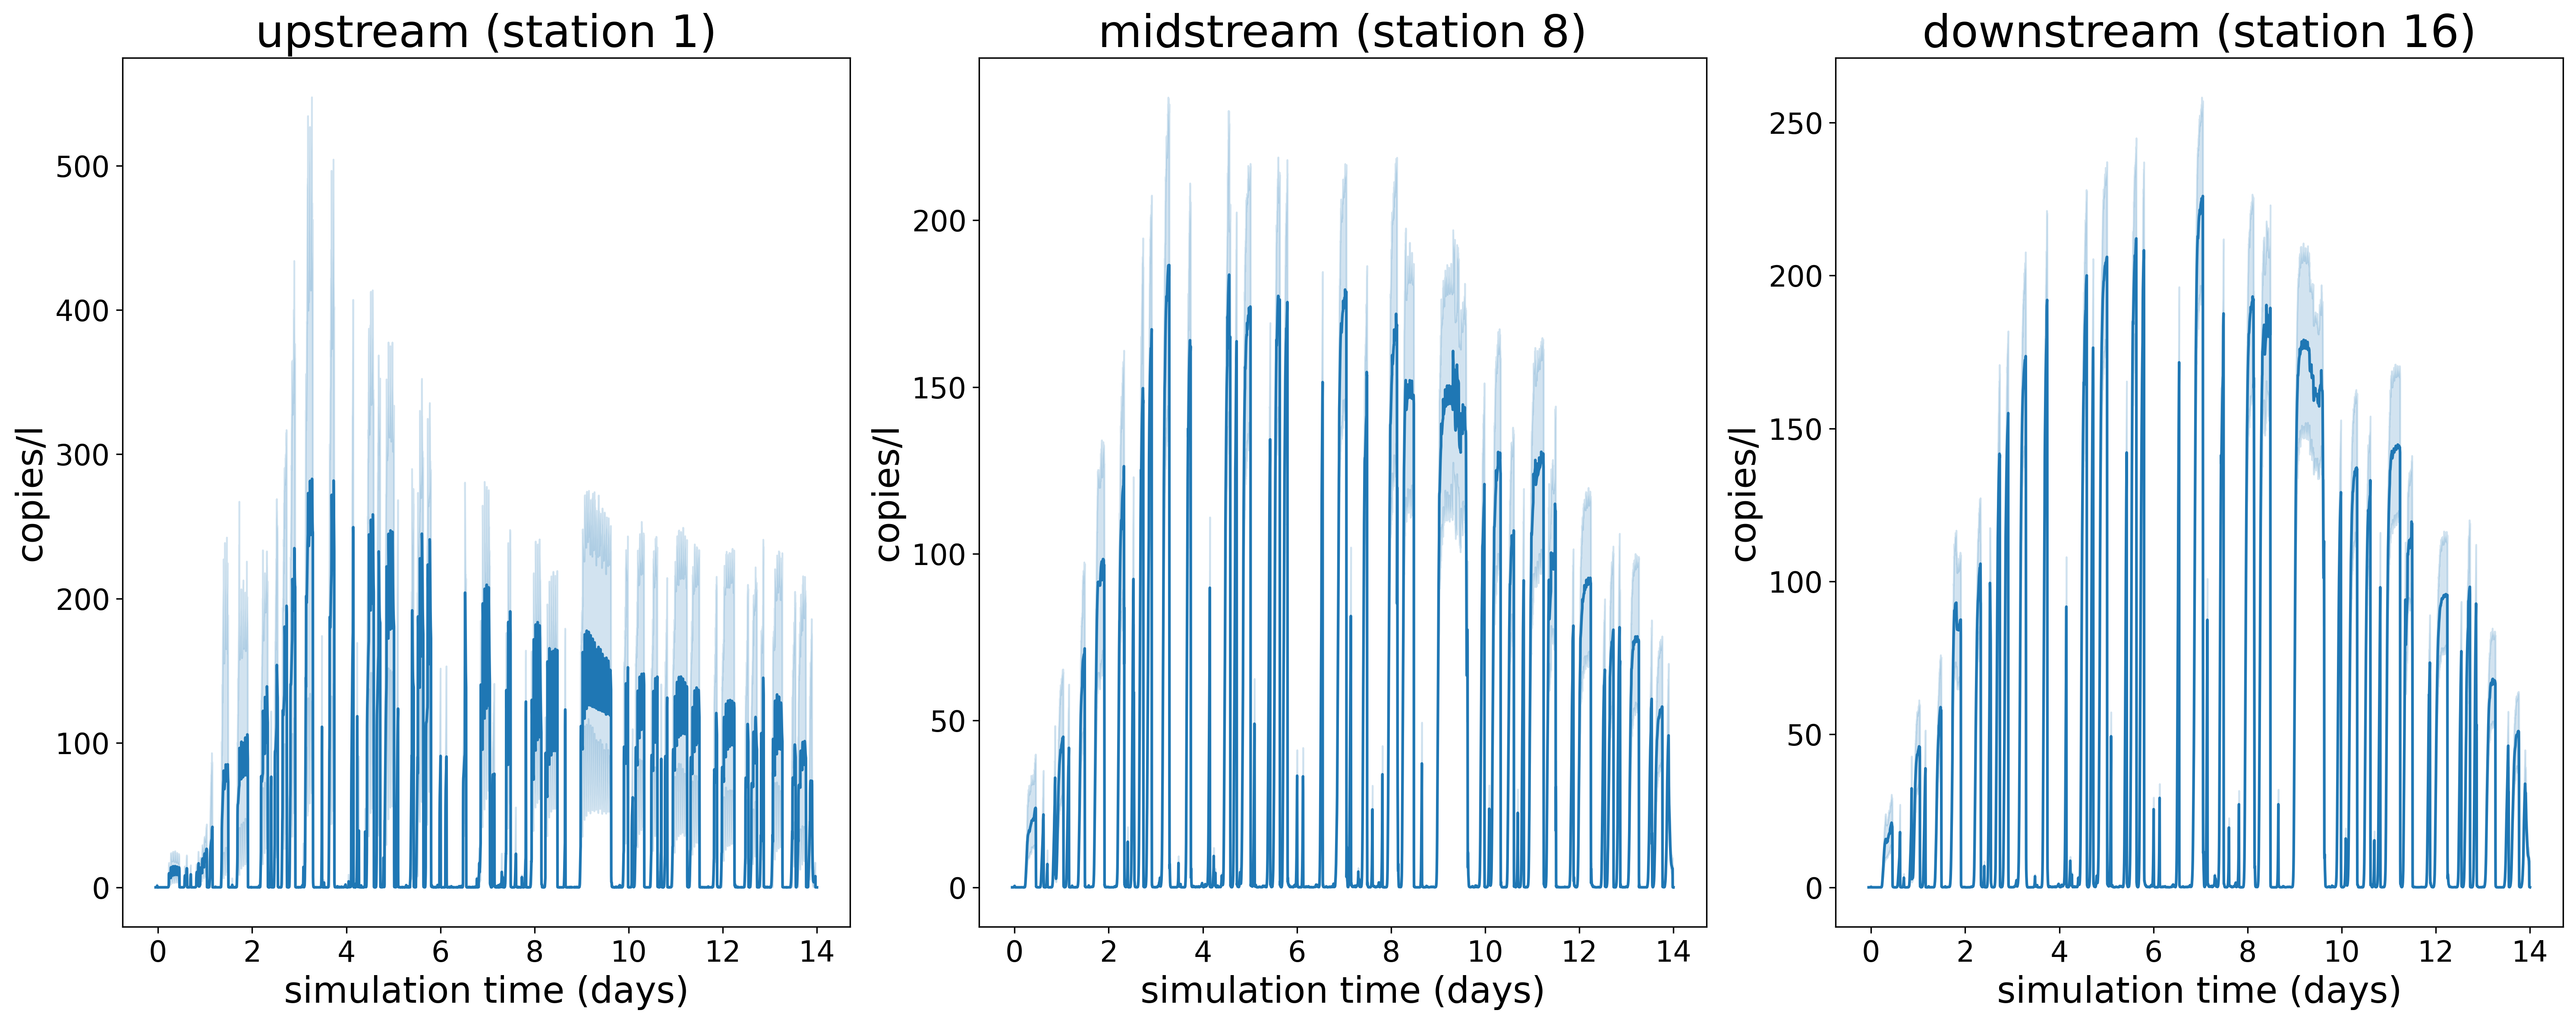

In [18]:
date_form = DateFormatter("%-d")

fig, axs = plt.subplots(ncols=3, sharey=False, figsize=(20, 8), dpi=300)
for i, (variate, variate_title) in enumerate(zip(["1", "8", "16"], ["upstream (station 1)", "midstream (station 8)", "downstream (station 16)"])):
    sns.lineplot(data=df_res.loc[df_res.sampling_point==variate,:], x="time", y="copies/l", ax=axs[i])
    axs[i].set_title(f"{variate_title}", fontsize=25)    
    axs[i].xaxis.set_major_formatter(date_form) 
    axs[i].set_xlabel(f"simulation time (days)", fontsize=20) # , fontsize=15
    axs[i].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
    axs[i].set_ylabel("copies/l", fontsize=20)
    axs[i].tick_params(axis='x', labelsize=16)
    axs[i].tick_params(axis='y', labelsize=16)

fig.tight_layout()
fig.savefig(os.path.join("systems_output", "plots", "station_concentration", f"{rain_scenario}_{degradation_setting}_up_mid_down.png"))

0 0 0 1


/tmp/ipykernel_57564/1443360407.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


1 0 1 2


/tmp/ipykernel_57564/1443360407.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


2 0 2 3


/tmp/ipykernel_57564/1443360407.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


3 0 3 4


/tmp/ipykernel_57564/1443360407.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


4 1 0 5


/tmp/ipykernel_57564/1443360407.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


5 1 1 6


/tmp/ipykernel_57564/1443360407.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


6 1 2 7


/tmp/ipykernel_57564/1443360407.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


7 1 3 8


/tmp/ipykernel_57564/1443360407.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


8 2 0 9


/tmp/ipykernel_57564/1443360407.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


9 2 1 10


/tmp/ipykernel_57564/1443360407.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


10 2 2 11


/tmp/ipykernel_57564/1443360407.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


11 2 3 12


/tmp/ipykernel_57564/1443360407.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


12 3 0 13


/tmp/ipykernel_57564/1443360407.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


13 3 1 14


/tmp/ipykernel_57564/1443360407.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


14 3 2 15


/tmp/ipykernel_57564/1443360407.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


15 3 3 16


/tmp/ipykernel_57564/1443360407.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


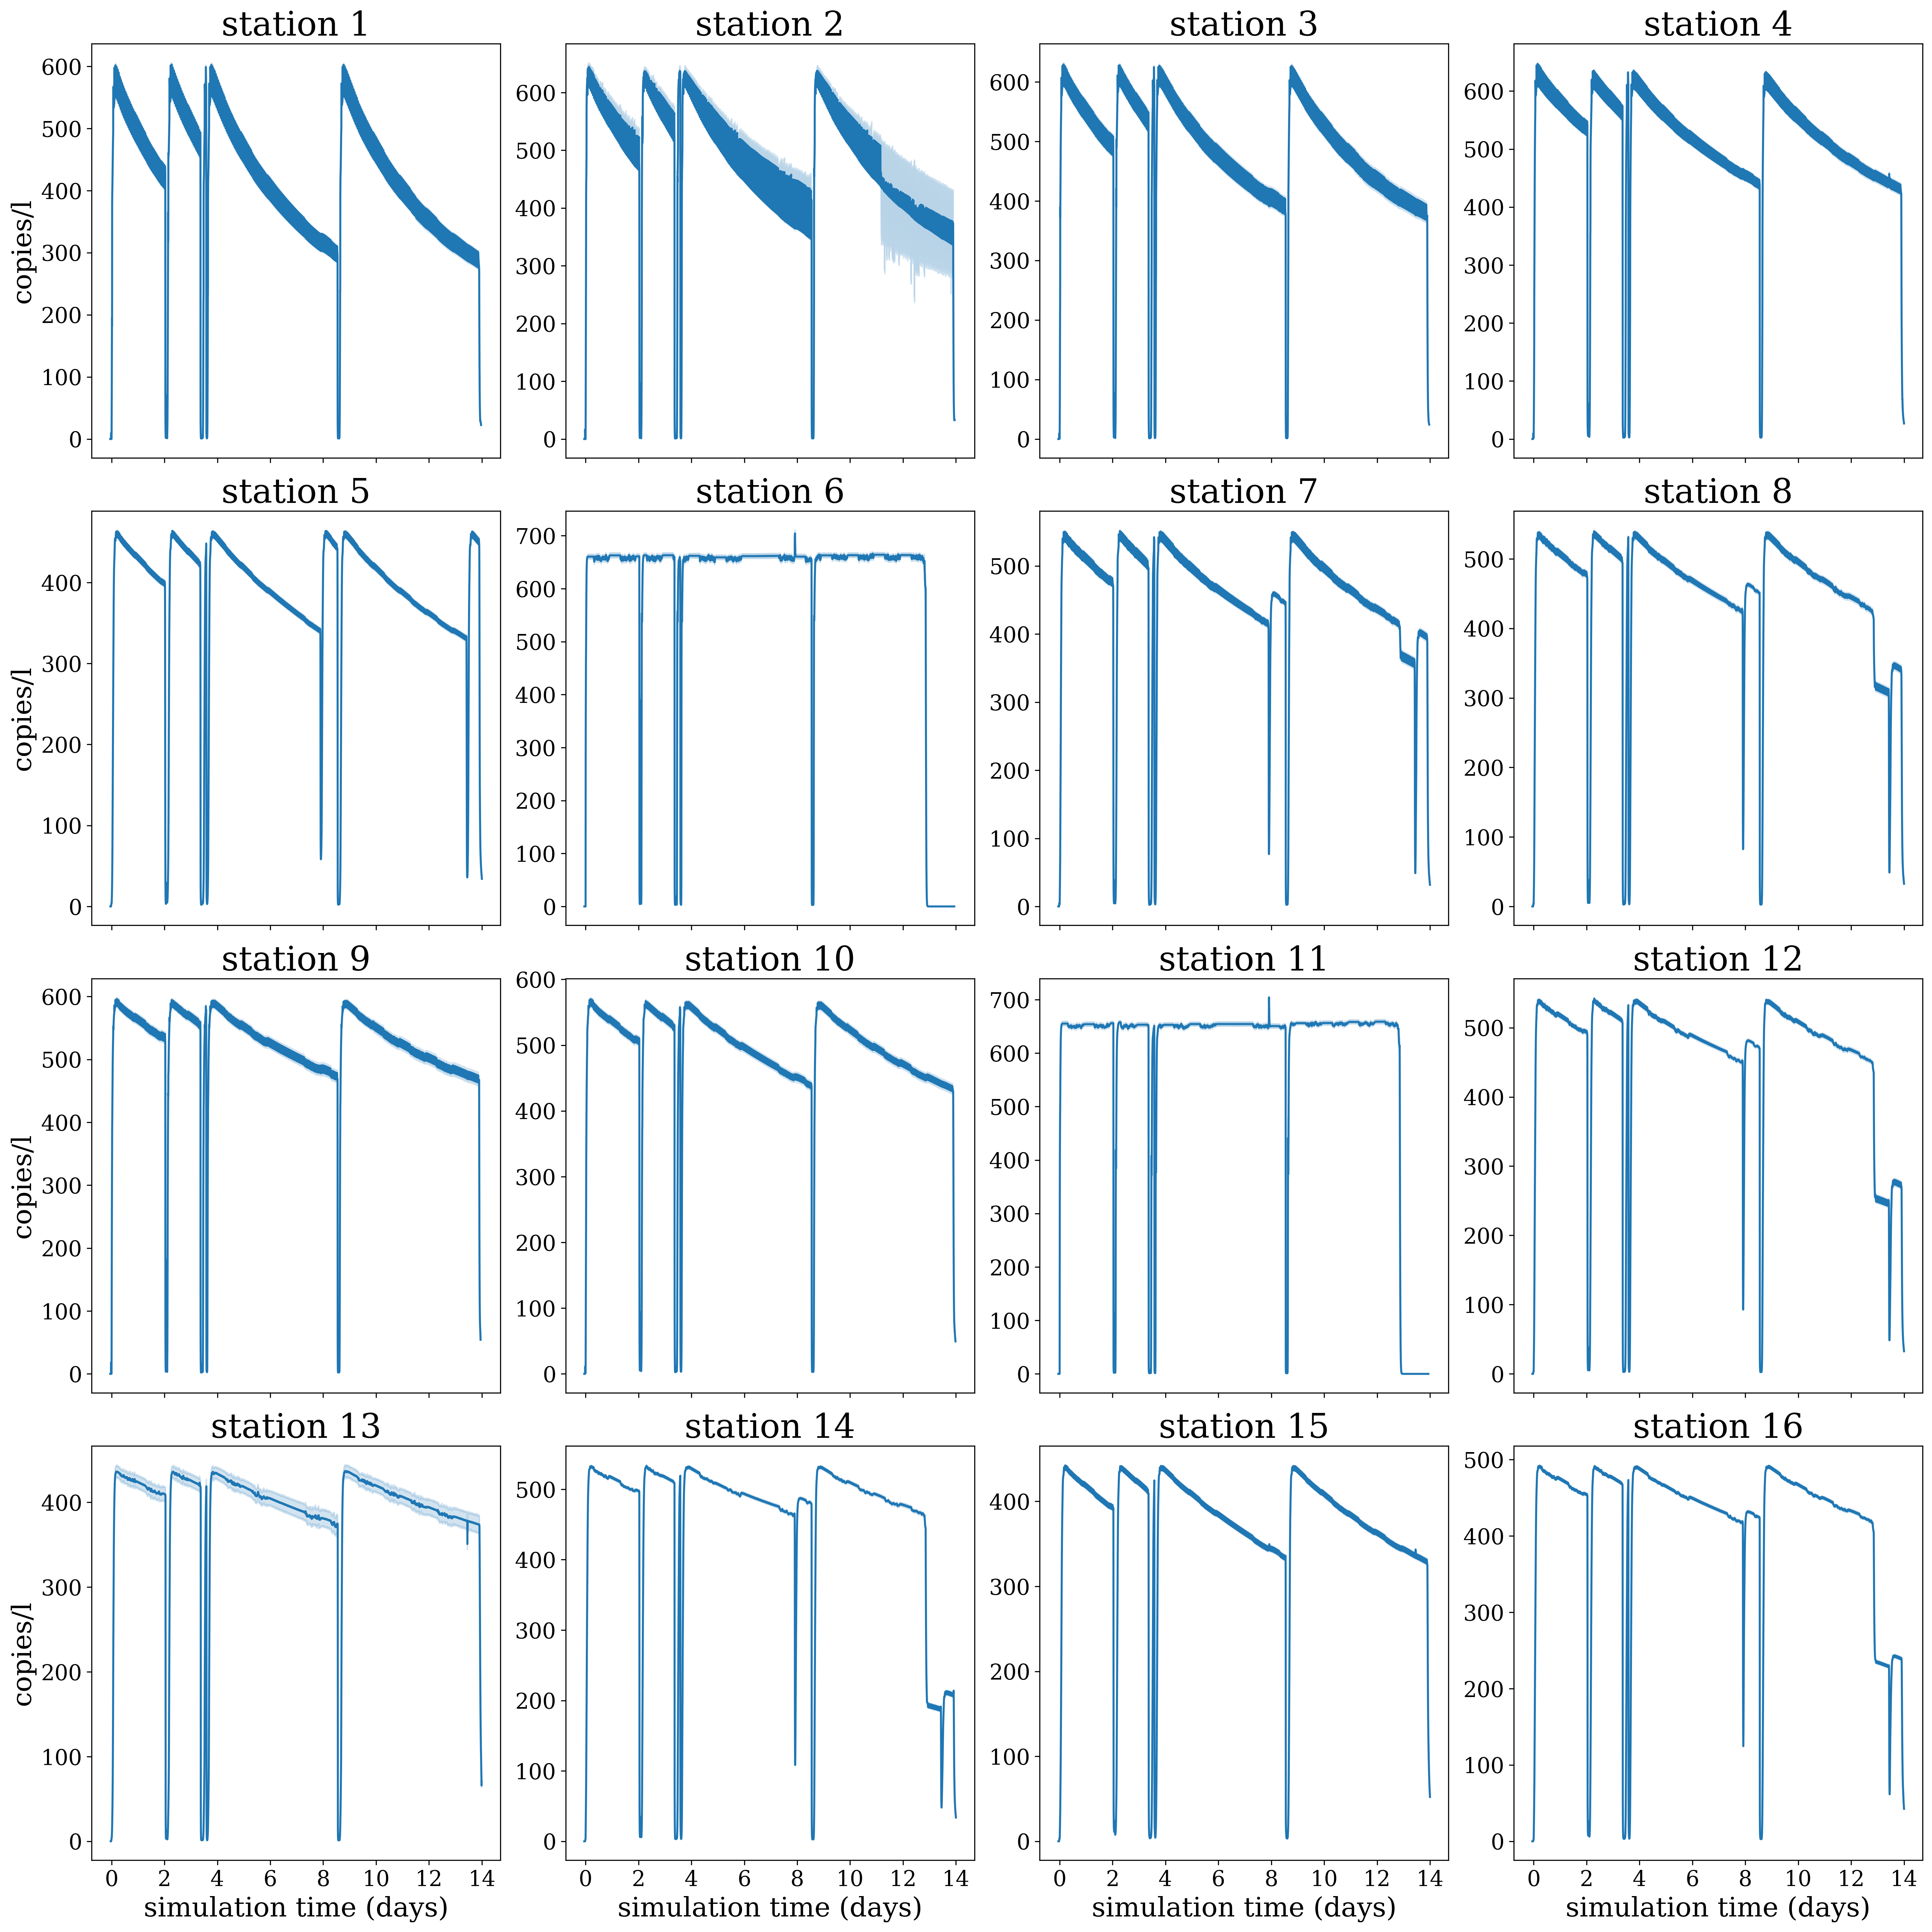

In [17]:
date_form = DateFormatter("%-d")

stations = [str(el) for el in range(1, 17)]

fig, axs = plt.subplots(ncols=4, nrows = 4, sharex = True, sharey=False, figsize=(20, 20), dpi=300)
j = 0
for i, (variate, variate_title) in enumerate(zip(stations, [f"station {el}" for el in stations])):
    col = i - j*4
    print(i, j, col, variate)
    sns.lineplot(data=df_res.loc[df_res.sampling_point==variate,:], x="time", y="copies/l", ax=axs[j, col])
    axs[j, col].set_title(f"{variate_title}", fontsize=25)    
    axs[j, col].xaxis.set_major_formatter(date_form)
    axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
    if j == 3:
        axs[j, col].set_xlabel(f"simulation time (days)", fontsize=20) # , fontsize=15
    else:
        axs[j, col].set_xlabel("")
    if col==0:
        axs[j, col].set_ylabel("copies/l", fontsize=20)
    else:
        axs[j, col].set_ylabel("")
    axs[j, col].tick_params(axis='x', labelsize=16)
    axs[j, col].tick_params(axis='y', labelsize=16)
    if col==3:
        j += 1
    

fig.tight_layout()
fig.savefig(os.path.join("systems_output", "plots", "station_concentration", f"{rain_scenario}_{degradation_setting}_all_stations.png"))

#### Visualization of Flow Rates

In [10]:
df_res = load_systems_data(degradation_setting, rain_scenario, file_type="flow_rates")

In [11]:
df_res.head()

minutes      l/s sampling_point  memilio_id                time
0       15  0.00462             16         188 2024-01-01 00:15:00
1       22  0.01112             16         188 2024-01-01 00:22:00
2       23  0.01251             16         188 2024-01-01 00:23:00
3       24  0.01473             16         188 2024-01-01 00:24:00
4       25  0.01723             16         188 2024-01-01 00:25:00

0 0 0 1


/tmp/ipykernel_77376/1576400749.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


1 0 1 2


/tmp/ipykernel_77376/1576400749.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


2 0 2 3


/tmp/ipykernel_77376/1576400749.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


3 0 3 4


/tmp/ipykernel_77376/1576400749.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


4 1 0 5


/tmp/ipykernel_77376/1576400749.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


5 1 1 6


/tmp/ipykernel_77376/1576400749.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


6 1 2 7


/tmp/ipykernel_77376/1576400749.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


7 1 3 8


/tmp/ipykernel_77376/1576400749.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


8 2 0 9


/tmp/ipykernel_77376/1576400749.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


9 2 1 10


/tmp/ipykernel_77376/1576400749.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


10 2 2 11


/tmp/ipykernel_77376/1576400749.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


11 2 3 12


/tmp/ipykernel_77376/1576400749.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
/tmp/ipykernel_77376/1576400749.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


12 3 0 13
13 3 1 14


/tmp/ipykernel_77376/1576400749.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
/tmp/ipykernel_77376/1576400749.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


14 3 2 15
15 3 3 16


/tmp/ipykernel_77376/1576400749.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])


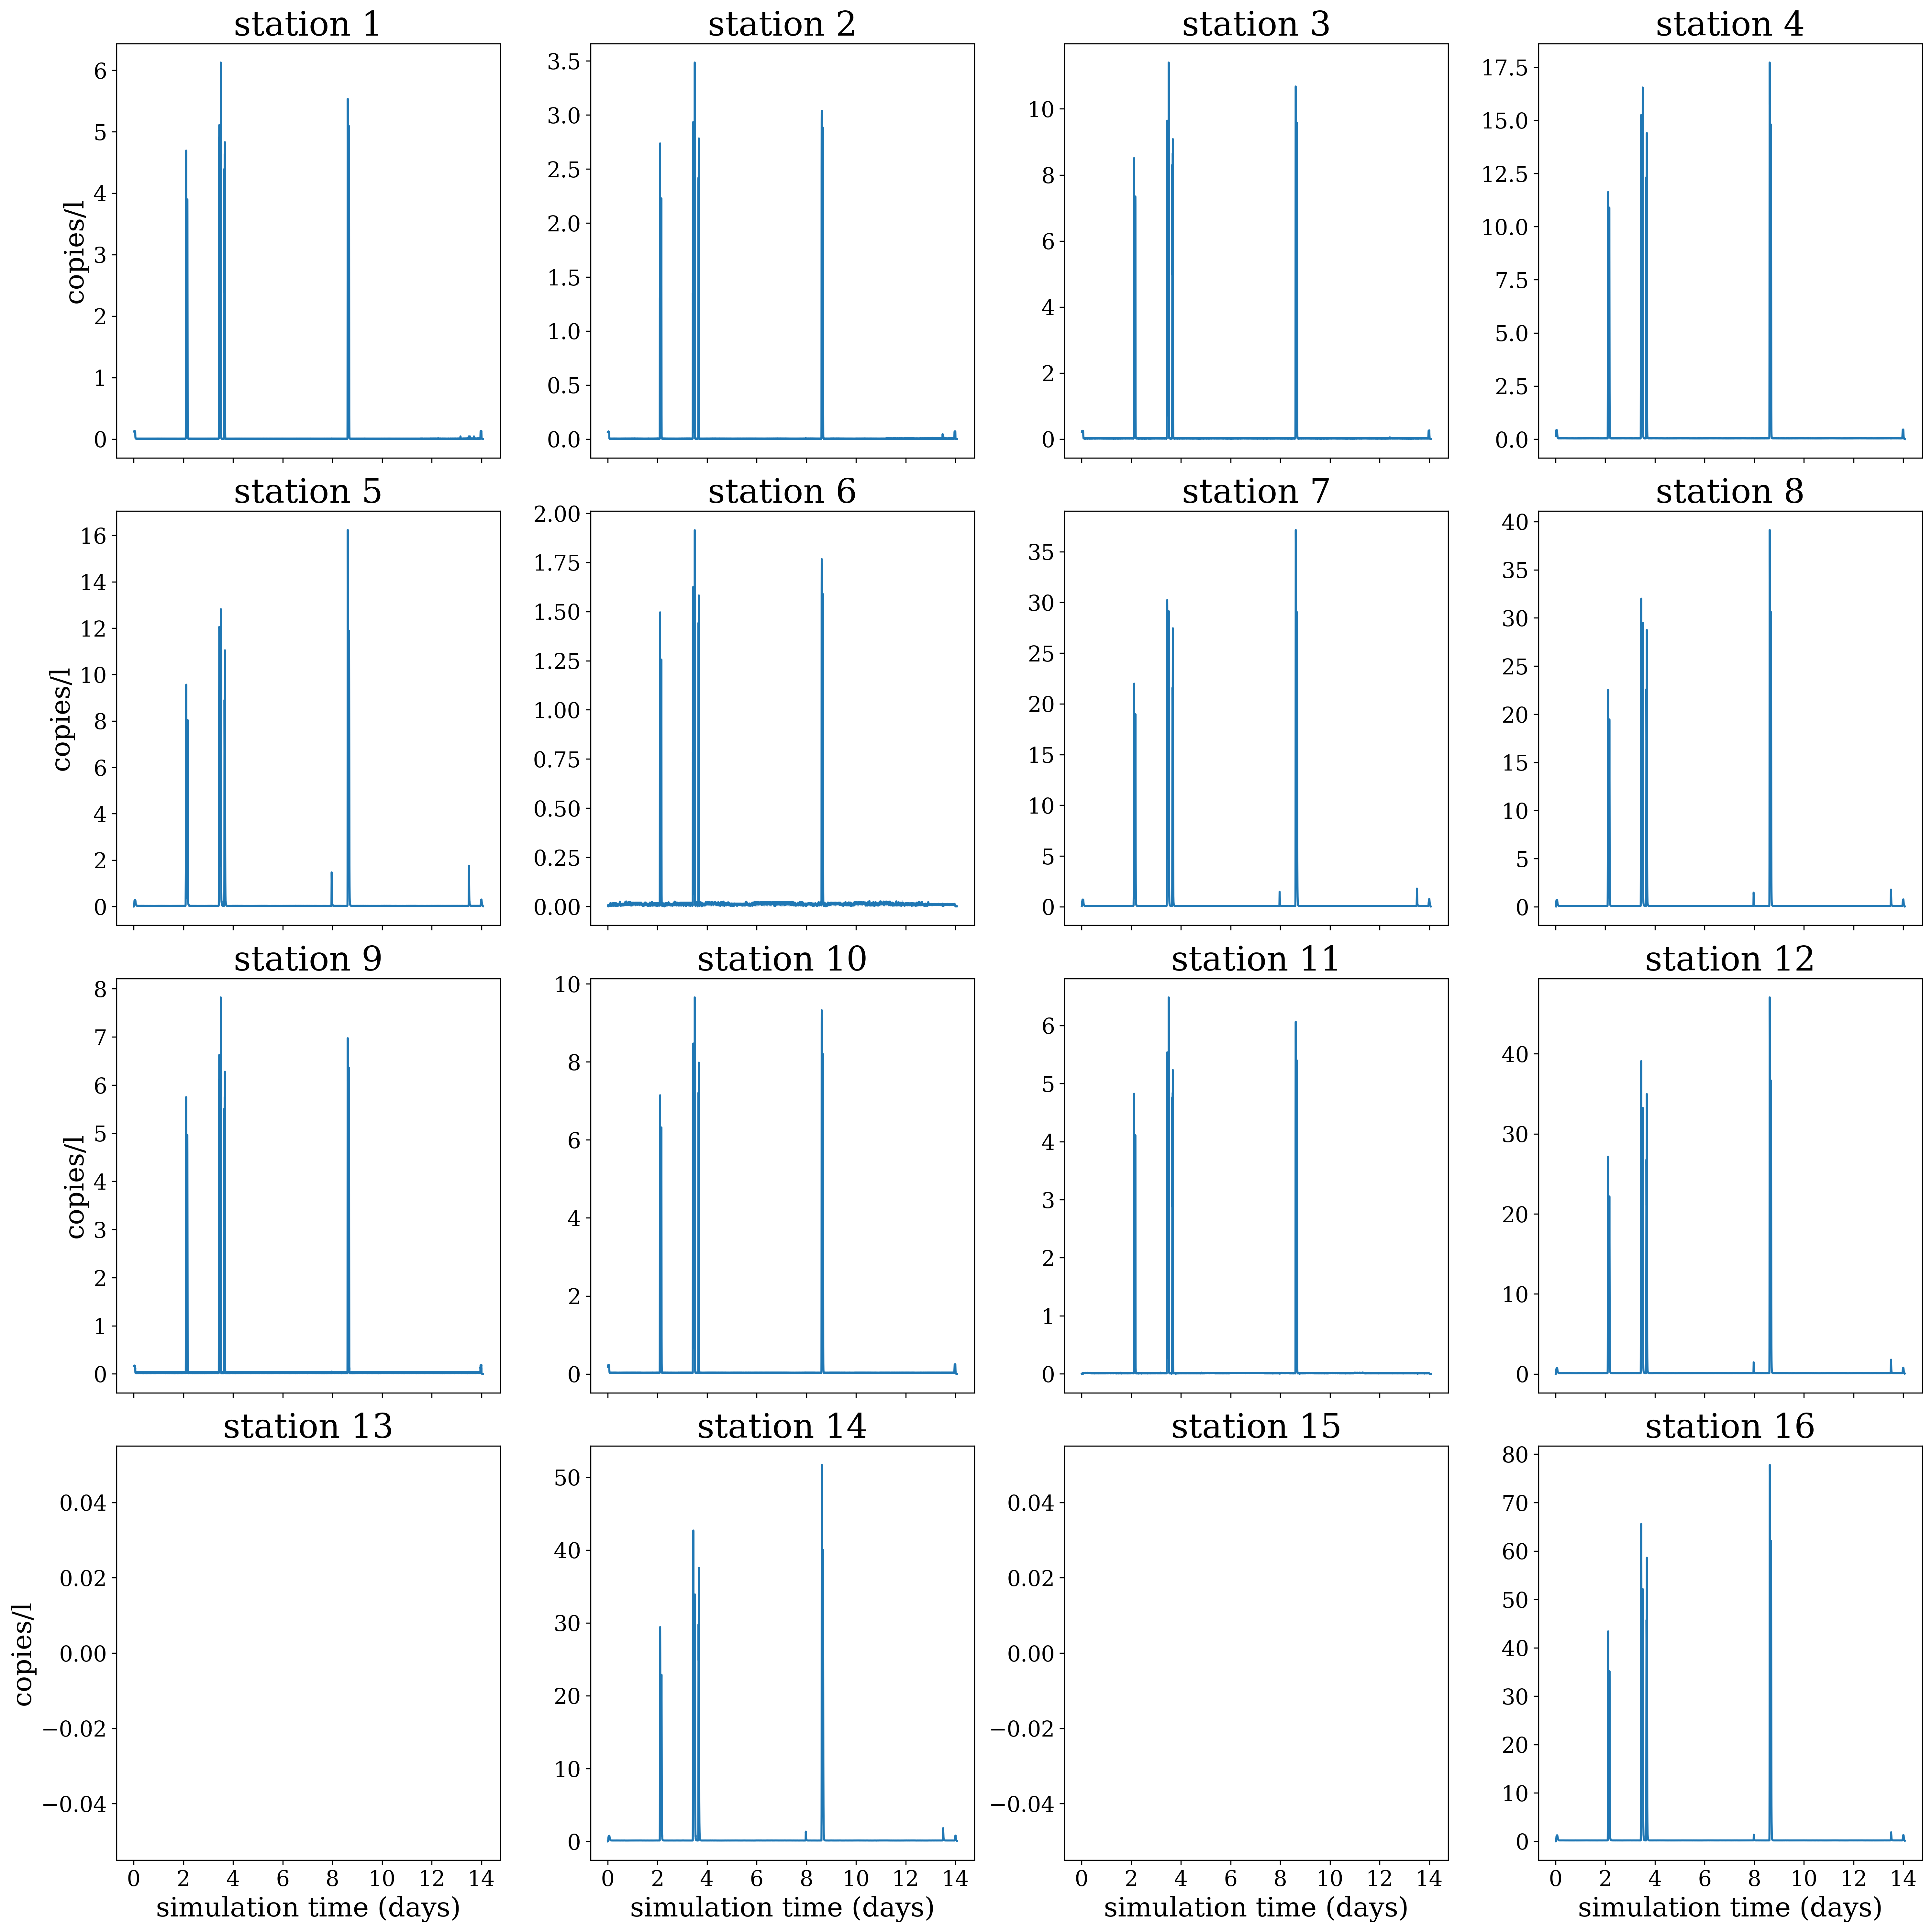

In [13]:
date_form = DateFormatter("%-d")

stations = [str(el) for el in range(1, 17)]

fig, axs = plt.subplots(ncols=4, nrows = 4, sharex = True, sharey=False, figsize=(20, 20), dpi=300)
j = 0
for i, (variate, variate_title) in enumerate(zip(stations, [f"station {el}" for el in stations])):
    col = i - j*4
    print(i, j, col, variate)
    sns.lineplot(data=df_res.loc[df_res.sampling_point==variate,:], x="time", y="l/s", ax=axs[j, col])
    axs[j, col].set_title(f"{variate_title}", fontsize=25)    
    axs[j, col].xaxis.set_major_formatter(date_form)
    axs[j, col].set_xticklabels(["0", "2", "4", "6", "8", "10", "12", "14"])
    if j == 3:
        axs[j, col].set_xlabel(f"simulation time (days)", fontsize=20) # , fontsize=15
    else:
        axs[j, col].set_xlabel("")
    if col==0:
        axs[j, col].set_ylabel("copies/l", fontsize=20)
    else:
        axs[j, col].set_ylabel("")
    axs[j, col].tick_params(axis='x', labelsize=16)
    axs[j, col].tick_params(axis='y', labelsize=16)
    if col==3:
        j += 1
    

fig.tight_layout()
fig.savefig(os.path.join("systems_output", "plots", "flow_rates", f"{rain_scenario}_{degradation_setting}_all_stations.png"))